Import the "Chembl" dataset and remove the row whose activity type is intermediate 

In [17]:
import pandas as pd
import os
df = pd.read_csv('./Dataset/O00519_CHEMBL2243.csv')
if not os.path.exists('./output/O00519'):
    os.makedirs('./output/O00519')
if not os.path.exists('./output/Trained_Models'):
    os.makedirs('./output/Trained_Models')
    
for x in df.index:
    if df.loc[x, 'Activity_type'] == "Intermediate":
        df.drop(x,inplace=True)

df = df.rename(columns={'canonical_smiles (Canonical)': 'smile'})

display(df)
print(df.shape)

,accession,target_type,pref_name,chembl_id,standard_value,standard_units,standard_type,pchembl_value,chembl_id_ligand,max_phase,...,heavy_atoms,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,year,Activity_type,smile,ExactMW,QED
0,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"0,01",nM,IC50,"11,0",CHEMBL3798535,NaN,...,33,7,0,1,"-0,8",2016,Active,COc1ccc(OC(=O)N2CCC(c3nc(C4=NOC(c5ccccc5)C4)cs...,"463,1565773","0,506834421"
1,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"0,01",nM,IC50,"11,0",CHEMBL3797772,NaN,...,32,7,0,0,"-1,42",2016,Active,O=C(Oc1ccc(Cl)cc1)N1CCN(c2nc(C3=NOC(c4ccccc4)C...,"468,1022892","0,539660554"
2,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"0,0128",nM,Ki,"10,89",CHEMBL3798476,NaN,...,33,7,0,1,"-1,11",2016,Active,N#Cc1ccc(OC(=O)N2CCC(c3nc(C4=NOC(c5ccccc5)C4)c...,"458,1412616","0,532200082"
3,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"0,0147",nM,Ki,"10,83",CHEMBL3798355,NaN,...,35,7,0,2,"-1,4",2016,Active,O=C(Oc1ccc(C(F)(F)F)cc1)N1CCN(c2nc(C3=NOC(c4cc...,"502,1286462","0,481390541"
4,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"0,0185",nM,Ki,"10,73",CHEMBL3800599,NaN,...,32,6,0,1,"-0,93",2016,Active,Cc1ccc(OC(=O)N2CCC(c3nc(C4=NOC(c5ccccc5)C4)cs3...,"447,1616627","0,514943158"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"89000,0",nM,IC50,"4,05",CHEMBL574358,NaN,...,14,3,0,0,"-1,39",2009,Inactive,O=C1C=CC(=O)N1c1cccc(F)c1,"191,0382567","0,626360943"
1604,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"92100,0",nM,IC50,"4,04",CHEMBL1795471,NaN,...,30,6,1,0,"-1,14",2011,Inactive,O=C(NCc1ccc2c(c1)OCO2)c1cc(-c2ccc(-c3ccccc3)cc...,"398,1266571","0,528963612"
1605,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"97723,72",nM,IC50,"4,01",CHEMBL2158921,NaN,...,22,8,0,0,"-1,35",2012,Inactive,O=C1CCN(C(=S)Sc2ccc([N+](=O)[O-])cc2[N+](=O)[O...,"341,0140125","0,3571841"
1606,O00519,SINGLE PROTEIN,Anandamide amidohydrolase,CHEMBL2243,"100000,0",nM,IC50,"4,0",CHEMBL1241252,NaN,...,16,1,0,0,"-0,42",2010,Inactive,CC(C(=O)C1SCCCS1)c1ccccc1,"252,0642571","0,818600881"


(1263, 27)


In [18]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors

def calculate_fp(molecule, method='maccs'):
    # Calculate the fingerprint of a molecule.
    return rdMolDescriptors.GetMorganFingerprintAsBitVect(molecule, 2)


def to_fingerprint(data_df, fp_name, verbose=False):
    """
    Calculate the specified fingerprint for each molecule in the DataFrame.
    Args:
        df: Pandas DataFrame containing 'smiles' column.
        fp_name: Name of the fingerprint method to use.
        verbose: If True, print status messages during execution.
    Returns:
        Modified DataFrame with the calculated fingerprint column.
    """
    df_fp = data_df.copy()
    if verbose:
        print('> Constructing a molecule from SMILES and Creating fingerprints')
    df_fp['molecule'] = df_fp.smile.map(lambda smile: Chem.MolFromSmiles(smile))
    df_fp[fp_name] = df_fp.molecule.apply(calculate_fp, args=[fp_name])
    # df_fp = df_fp.drop(['smile'], axis=1)
    return df_fp

In [19]:
import numpy as np

def decode_fingerprints(data_df):
    # Decode fingerprints stored in DataFrame into a numerical format.
    decoded_fingerprints = []
    for fp in data_df['morgan2_c']:
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        decoded_fingerprints.append(arr)
    return np.array(decoded_fingerprints)

Remove some columns and convert the dataset such that model requires only input features and target type

In [20]:
from sklearn.model_selection import train_test_split

df_fingerprints = to_fingerprint(df, 'morgan2_c')
df_fingerprints.to_csv('./fingerprints.csv', index=False)  # Save fingerprints
df_fingerprints = decode_fingerprints(df_fingerprints)

print(df_fingerprints.shape)
display(df_fingerprints)

# print(X)
# print(X.shape)
# print(Y)
# print(Y.shape)


(1263, 2048)


[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerator
[15:31:40] DEPRECATION WARNING: please use MorganGenerat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], shape=(1263, 2048))

Split the Dataset using random seed

In [21]:
from sklearn.model_selection import train_test_split

x=df_fingerprints


In [22]:
y = df['Activity_type'].map({'Inactive': 0, 'Active': 1})
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=20)

display(X_train, Y_train)
display(X_test, Y_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1010, 2048))

299     1
736     1
1522    0
569     1
460     1
       ..
1587    0
1269    0
1592    0
271     1
474     1
Name: Activity_type, Length: 1010, dtype: int64

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(253, 2048))

1605    0
521     1
1306    0
772     1
744     1
       ..
1468    0
1520    0
254     1
1555    0
183     1
Name: Activity_type, Length: 253, dtype: int64

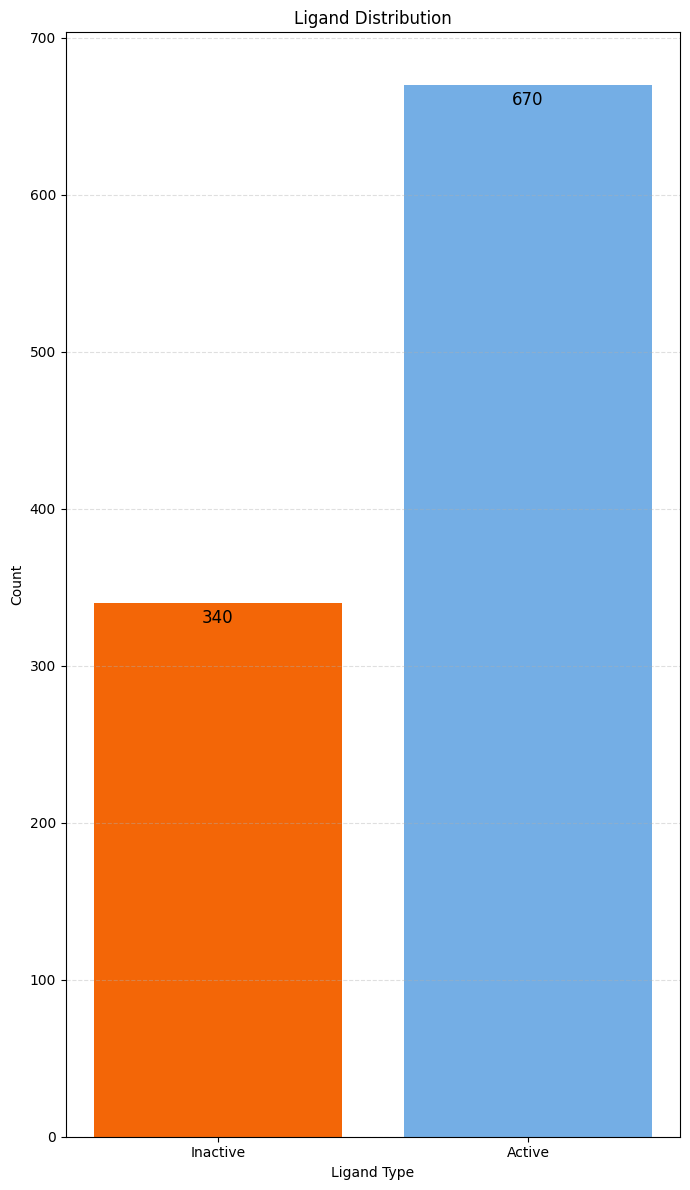

In [23]:
import matplotlib.pyplot as plt

# Count active and inactive ligands in Y_train (after encoding: 0=Inactive, 1=Active)
ligand_counts = Y_train.value_counts()

# Define correct label mapping
label_names = {0: 'Inactive', 1: 'Active'}
ordered_labels = [0, 1]  # Integer labels for order
ordered_counts = [ligand_counts[label] for label in ordered_labels]

# Define custom colors for labels
colors = {
    'Active': "#74aee5",     # Blue
    'Inactive': "#f36607"    # Orange
}

# Create the bar plot
plt.figure(figsize=(7, 12))
bars = plt.bar(
    [label_names[l] for l in ordered_labels],  # Convert to 'Inactive', 'Active'
    ordered_counts,
    color=[colors[label_names[l]] for l in ordered_labels]
)

# Add count labels above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height - 4 ,  # Inside the bar
        f'{int(height)}', ha='center', va='top',
        color='black', fontsize=12
    )

plt.title('Ligand Distribution')
plt.xlabel('Ligand Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('./output/O00519/ligand_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [42]:
import optuna
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import warnings
import warnings

# ✅ Suppress logs from trials (this removes the multiline output)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optional: suppress UserWarnings from XGBoost
warnings.filterwarnings("ignore", category=UserWarning)

# Objective function
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
    }

    model = xgb.XGBClassifier(
        **param,
        tree_method='hist',
        device='cpu',
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0  # silent logging
    )

    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    score = balanced_accuracy_score(Y_test, preds)
    return score

# Create study
study = optuna.create_study(study_name="xgb_balanced_acc", direction='maximize')

# 🔄 Run optimization with a SINGLE PROGRESS BAR ABOVE all output
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# ✅ Final result after the bar
print("\nBest trial:")
print(f"Value (Balanced Accuracy): {study.best_value:.4f}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k:20}: {v}")


Best trial: 968. Best value: 0.903437: 100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


Best trial:
Value (Balanced Accuracy): 0.9034
Best Parameters:
max_depth           : 19
learning_rate       : 0.5934826246167174
n_estimators        : 100
subsample           : 0.9112230580360721
colsample_bytree    : 0.5570485925068291
min_child_weight    : 1
gamma               : 0.2849604628653789
reg_alpha           : 0.9684669774371244
reg_lambda          : 0.9187463767865401
scale_pos_weight    : 1.276904786337969


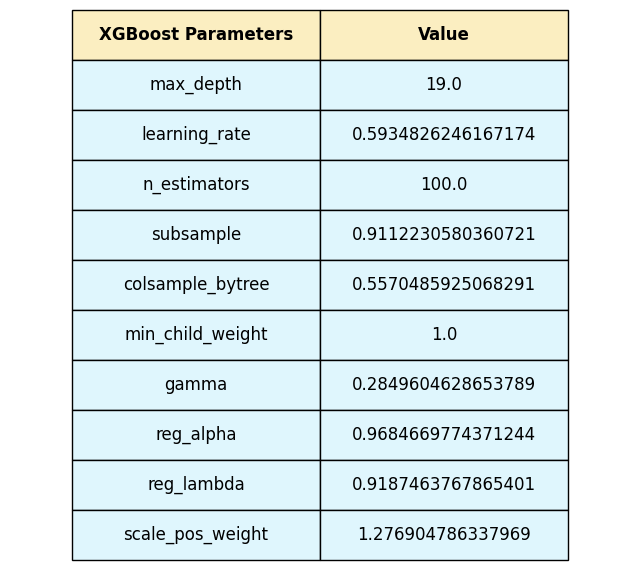

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert best parameters to DataFrame
params_df = pd.DataFrame.from_dict(study.best_params, orient='index', columns=['Value'])
params_df.index.name = 'XGBoost Parameters'
params_df.reset_index(inplace=True)

# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(8, len(params_df)*0.6))  # Auto-adjust height

# Hide axes
ax.axis('off')

# Create table
table = ax.table(
    cellText=params_df.values,
    colLabels=params_df.columns,
    cellLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 3)

# Color header
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#fbeec1')  # Light yellow for header
    else:
        cell.set_facecolor('#dff6fd')  # Light blue rows

# Save as PNG
plt.savefig('./output/O00519/best_xgboost_params.png', dpi=300, bbox_inches='tight')
plt.show()


In [44]:
model = xgb.XGBClassifier(
    **study.best_params,
    tree_method='hist',
    device='cpu',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

model.fit(X_train, Y_train)

# Predictions
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)


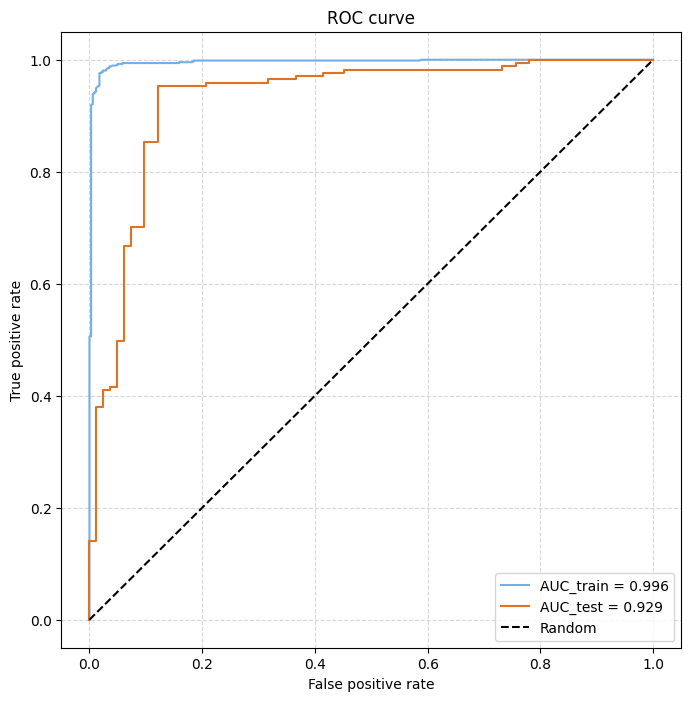

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_combined_roc(y_train, train_probs, y_test, test_probs):
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

    auc_train = roc_auc_score(y_train, train_probs)
    auc_test = roc_auc_score(y_test, test_probs)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, color="#74aee5", label=f'AUC_train = {auc_train:.3f}')
    plt.plot(fpr_test, tpr_test, color="#e27120", label=f'AUC_test = {auc_test:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')

    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig('./output/O00519/roc_curve_combined.png', dpi=300, bbox_inches='tight')
    plt.show()

# After fitting your model and generating probabilities
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

plot_combined_roc(Y_train, train_probs, Y_test, test_probs)


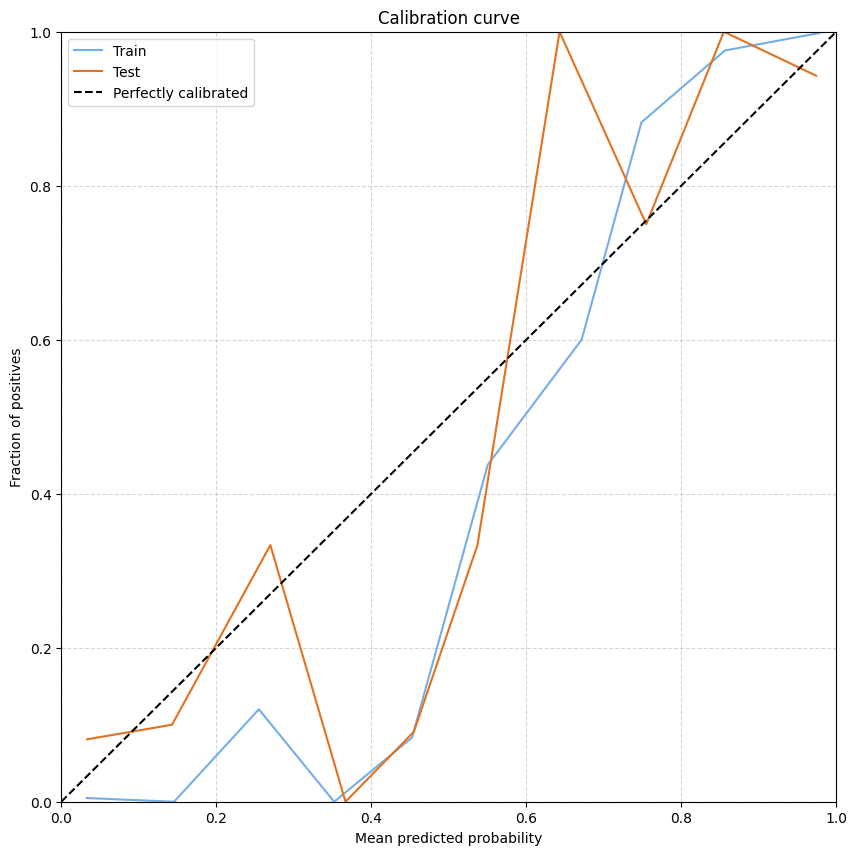

In [46]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_combined_calibration(y_train, train_probs, y_test, test_probs, n_bins=10):
    prob_true_train, prob_pred_train = calibration_curve(y_train, train_probs, n_bins=n_bins)
    prob_true_test, prob_pred_test = calibration_curve(y_test, test_probs, n_bins=n_bins)

    plt.figure(figsize=(10, 10))
    plt.plot(prob_pred_train, prob_true_train,  color="#74aee5", label='Train')
    plt.plot(prob_pred_test, prob_true_test,  color="#e27120", label='Test')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

    plt.title('Calibration curve')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig('./output/O00519/calibration_curve_combined.png', dpi=300, bbox_inches='tight')
    plt.show()

# After fitting your model:
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

plot_combined_calibration(Y_train, train_probs, Y_test, test_probs)


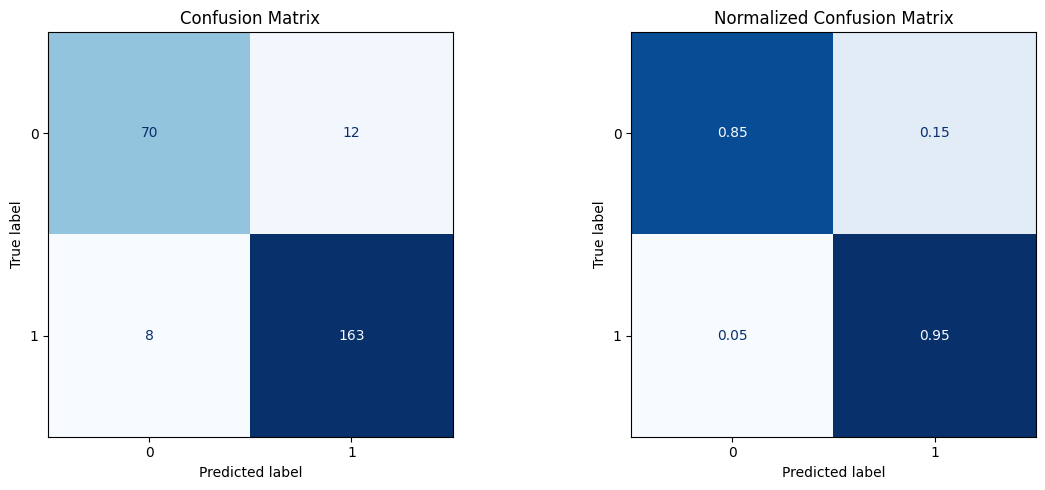

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred, labels=None):
    # Standard confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot standard
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title("Confusion Matrix")

    # Plot normalized
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
    disp_norm.plot(cmap='Blues', ax=ax[1], colorbar=False, values_format='.2f')
    ax[1].set_title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.savefig('./output/O00519/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

# After model predictions
test_preds = model.predict(X_test)

# Plot confusion matrices
plot_confusion_matrices(Y_test, test_preds)



In [48]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def compute_metrics_table(y_true_train, y_pred_train, y_prob_train,
                          y_true_test, y_pred_test, y_prob_test):
    
    def compute_all(y_true, y_pred, y_prob):
        auc = roc_auc_score(y_true, y_prob)
        acc = accuracy_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp)
        
        return {
            'AUC': auc,
            'Accuracy': acc,
            'Balanced Accuracy': bal_acc,
            'Specificity': spec,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        }

    train_metrics = compute_all(y_true_train, y_pred_train, y_prob_train)
    test_metrics = compute_all(y_true_test, y_pred_test, y_prob_test)

    df = pd.DataFrame({
        'Train': train_metrics,
        'Test': test_metrics
    })

    # Display table
    print("\n📊 Metrics Summary:")
    print(df.round(4))
    return df

train_probs = model.predict_proba(X_train)[:, 1]
train_preds = model.predict(X_train)
test_probs = model.predict_proba(X_test)[:, 1]
test_preds = model.predict(X_test)

metrics_df = compute_metrics_table(Y_train, train_preds, train_probs, Y_test, test_preds, test_probs)




📊 Metrics Summary:
                    Train    Test
AUC                0.9958  0.9288
Accuracy           0.9762  0.9209
Balanced Accuracy  0.9683  0.9034
Specificity        0.9441  0.8537
Precision          0.9722  0.9314
Recall             0.9925  0.9532
F1 Score           0.9823  0.9422


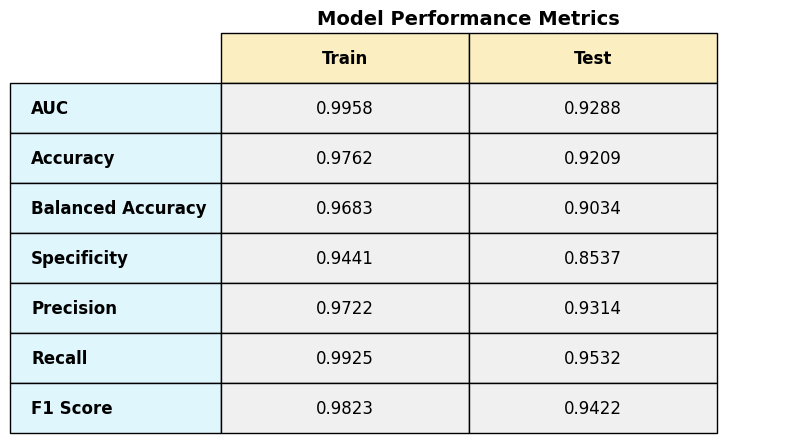

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_table(metrics_df):
    fig, ax = plt.subplots(figsize=(8, metrics_df.shape[0]*0.6+1))  # Adjust height dynamically
    ax.axis('off')

    # Create table
    table = ax.table(
        cellText=metrics_df.round(4).values,
        colLabels=metrics_df.columns,
        rowLabels=metrics_df.index,
        cellLoc='center',
        loc='center'
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.8, 3)

    # Header color
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#fbeec1')  # Light yellow for column headers
        elif col == -1:  # row labels (metric names)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#dff6fd')  # Light blue for row headers
        else:
            cell.set_facecolor('#f0f0f0')  # Light gray for cells

    plt.title('Model Performance Metrics', fontsize=14, weight='bold')
    plt.savefig('./output/O00519/metrics_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming you have `metrics_df` from previous function
plot_metrics_table(metrics_df)


In [50]:
import os

def save_xgb_model(model, folder_path, file_name="xgboost_model.json"):
    """
    Save the XGBoost model to a specified folder.

    Parameters:
    - model: trained XGBoost model (XGBClassifier or Booster)
    - folder_path: string, path to folder where model will be saved
    - file_name: string, name of the model file (default: xgboost_model.json)

    Returns:
    - Full file path where model is saved
    """
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Full file path
    file_path = os.path.join(folder_path, file_name)

    # Save the model
    model.save_model(file_path)

    print(f"✅ Model saved to: {file_path}")
    return file_path

# Example usage after training
# Assume: model = trained XGBClassifier
save_xgb_model(model, folder_path="./output/Trained_models", file_name="O00519_best_xgb_model.json")



✅ Model saved to: ./output/Trained_models/O00519_best_xgb_model.json


'./output/Trained_models/O00519_best_xgb_model.json'